In [171]:
using JuMP, GLPKMathProgInterface, Cbc, DataFrames, Plots, StatPlots, Random

## Funções auxiliares

In [172]:
function dados_e_plot(G, schedule_matrix, d, title; alpha = 0.4, CVaR = zeros(1:12), legend = false)
    if length(size(G)) == 1
        nplants = length(G)
    else
        nplants = size(G)[1]
    end
    if length(size(d)) == 1
        nmonths = length(d)
    else
        nmonths = size(d)[1]
        Ns = size(d)[2]
    end
    schedule = DataFrame(months = collect(1:nmonths), plants_off = [[] for i in 1:nmonths], capacity_available = collect(zeros(1:nmonths)))
    for plant in 1:nplants
        for month in 1:nmonths
            if round(schedule_matrix[plant, month] - 0.1) == 1.0
                push!(schedule.plants_off[month], plant)
            else
                if length(size(G)) == 1
                    schedule.capacity_available[month] += G[plant] 
                else
                    schedule.capacity_available[month] += G[plant, month]
                end
            end
        end
    end
    plot1 = heatmap(schedule_matrix, colorbar = false, xlabel = "Months", ylabel = "Plants", xaxis = collect(1:nmonths), yaxis = collect(1:nplants), color = :PuRd, aspect_ratio = 1)
    #plot1 = bar(collect(1:nmonths), [size(plants_off) for plants_off in schedule.plants_off], xlabel = "Months", ylabel = "Number of plants off", aspect_ratio = 1, xaxis = collect(1:nmonths), yaxis = collect(1:nplants), color = :redsblues)
    if length(size(d)) == 1
        return schedule, plot1, groupedbar([schedule.capacity_available d], title = title, label = ["capacity_available", "demand"], colour = [:green :red], legend = legend, xaxis = collect(1:nmonths), xlabel = "Months", ylabel = "Energy")
    else
        plot2 = groupedbar([schedule.capacity_available [maximum(d[month, :]) for month in 1:nmonths] [sum(d[month, :]) / Ns for month in 1:nmonths]], title = title, label = ["capacity_available", "greater_demand", "expected_value_demand"], colour = [:green :red :orange], legend = legend, xaxis = collect(1:nmonths), xlabel = "Months", ylabel = "Energy")
        if sum(CVaR) != 0
            bar!(CVaR, alpha = alpha, colour = :lightblue, label = "CVaR")
        end
        return schedule, plot1, plot2
    end
end;

In [239]:
function comparison(d, G, dados1, schedule_matrix1, dados2, schedule_matrix2; xlabel1 = "dados1", xlabel2 = "dados2", title = "Comparison of capacity available", legend1 = false)
    nplants = length(G)
    nmonths = size(dados1, 1)
    Ns = size(d)[2]
    plot1 = groupedbar([dados1.capacity_available dados2.capacity_available [maximum(d[month, :]) for month in 1:nmonths] [sum(d[month, :]) / Ns for month in 1:nmonths]], label = [xlabel1; xlabel2; ["Maximum demand"]; ["Expected value of demand"]], colour = [:green :blue :red :orange], xlabel = "Months", ylabel = "Capacity available", xaxis = collect(1:nmonths), title = title, legend = legend1)
    plot2 = bar(collect(1:nmonths), [size(dados1.plants_off[month])[1] for month in 1:nmonths], xaxis = collect(1:nmonths), ylabel = "N of plants turned off", xlabel = xlabel1, legend = false)
    plot3 = bar(collect(1:nmonths), [size(dados2.plants_off[month])[1] for month in 1:nmonths], xaxis = collect(1:nmonths), xlabel = xlabel2, legend = false)
    plot4 = heatmap(schedule_matrix1, colorbar = false, xlabel = "Months", ylabel = "Plants", xaxis = collect(1:nmonths), yaxis = collect(1:nplants), color = :PuRd)
    plot5 = heatmap(schedule_matrix2, colorbar = false, xlabel = "Months", xaxis = collect(1:nmonths), yaxis = collect(1:nplants), color = :PuRd)    
    plot6 = plot(plot2, plot3, plot4, plot5, layout = (2, 2), link = :y)
    return plot1, plot6
end;

In [174]:
#Valores padrão
G = [10, 5, 20, 18, 23, 32, 7, 12, 10, 20, 17, 32, 12, 13, 17]
d = [238, 220, 187, 175, 135, 127, 144, 165, 193, 205, 213, 233]
R = [33, 46, 32, 27, 10, 8, 20, 21, 37, 41, 27, 27]
θ = 0.2
Ns = 10
K = Int.(ones(length(G)))
cg = Int.(zeros(length(G)))

d_array = [[Int(round(d * 0.7)) for d in d]]
for scenario in 2:Ns
    push!(d_array, [Int(round(d * (0.4 + 0.6 * rand()))) for d in d])
end
ds = hcat(d_array...)
dsR = similar(ds)
for scenario in 1:Ns
    dsR[:, scenario] = ds[:, scenario] - R
end;

## 1.1 Heurística de solução para o problema de manutenção

Dado um conjunto de capacidades máximas $G_i$ de usinas $i$, a soma das capacidades das usinas que estão operando em um determinado mês é a capacidade disponível desse mês. Cada usina deve entrar em manutenção uma vez por ano. Deve-se distribuir as as paradas de manutenção das usinas durante um ano em uma agenda de manutenção, de modo que a $\textbf{menor das capacidades disponíveis dos meses seja maximizada}$.

A ideia neste caso é distribuir as doze usinas com maiores capacidades nos doze meses. A partir disso, distribuir as usinas restantes, cada uma, no mês que atualmente tem maior capacidade disponível.

In [175]:
function plants_in_a_year(G)
    capacity = sum(G)
    is = collect(range(1, stop = length(G)))
    G = collect(zip(is, G))
    sort!(G, by = G -> G[2], rev = true)
    months = [[month, capacity - G[plant][2], [G[plant][2]], [G[plant][1]]] for (month, plant) in zip(collect(1:12), shuffle(collect(1:12)))]
    G = copy(G[13:end])
    for plant in G
        sort!(months, by = month -> month[2], rev = true)
        push!(months[1][3], plant[2])
        push!(months[1][4], plant[1])
        months[1][2] -= plant[2]
    end
    sort!(months, by = month -> month[1])
    months = DataFrame(month = (month -> month[1]).(months), plants = (month -> month[4]).(months), capacity_available = (month -> month[2]).(months)) #, capacities_used = (month -> month[3]).(months))
    return months
end;

In [176]:
G1 = G
schedule1 = plants_in_a_year(G1)

,month,plants,capacity_available
,Int64,Array…,Int64
1,1,[12],216
2,2,"[13, 7]",229
3,3,[14],235
4,4,"[8, 2]",231
5,5,[3],228
6,6,[11],231
7,7,[5],225
8,8,[10],228
9,9,[6],216


## 1.2 Solução do problema de manutenção com otimização

In [177]:
G2 = G
d2 = d
nplants2 = length(G2)
nmonths2 = length(d2);

In [178]:
m2 = Model(solver = CbcSolver())

@variable(m2, x[1:nplants2, 1:nmonths2], Bin)
@variable(m2, α)

#Toda usina desliga uma vez no ano
@constraintref constraints1[1:nplants2]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m2, sum(x[plant, 1:nmonths2]) >= 1)
end

#α deve ser maior do que todas as diferenças entre a capacidade disponível e a demanda do mês
@constraintref constraints2[1:nmonths2]
for month in eachindex(constraints2)
    constraints2[month] = @constraint(m2, α >= sum(G2 .* (1 .- x[1:nplants2, month])) - d2[month])
end

#A demanda sempre deve ser suprida
@constraintref constraints3[1:nmonths2]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m2, sum(G2 .* (1 .- x[1:nplants2, month])) - d2[month] >= 0)
end

@objective(m2, Min, α);

In [179]:
solve(m2)
@show getvalue(α)
schedule_matrix2 = getvalue(x)

getvalue(α) = 0.0


15×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0
 1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0

In [180]:
dados2, plot1_2, plot2_2 = dados_e_plot(G2, schedule_matrix2, d2, "1.2 Solução do problema de manutenção com otimização", legend = true)
dados2

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[9],238.0
2,2,"[4, 9]",220.0
3,3,"[4, 5, 10]",187.0
4,4,"[2, 4, 5, 9, 11]",175.0
5,5,"[1, 4, 6, 7, 8, 11, 15]",135.0
6,6,"[2, 4, 6, 11, 12, 15]",127.0
7,7,"[2, 3, 5, 6, 7, 11]",144.0
8,8,"[8, 9, 11, 12, 13]",165.0
9,9,"[1, 10, 13, 14]",193.0


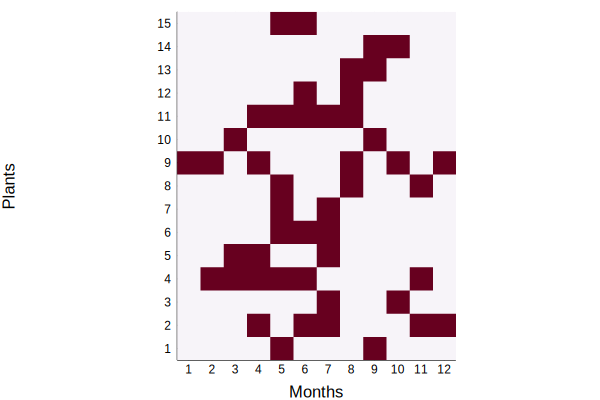

In [181]:
plot1_2

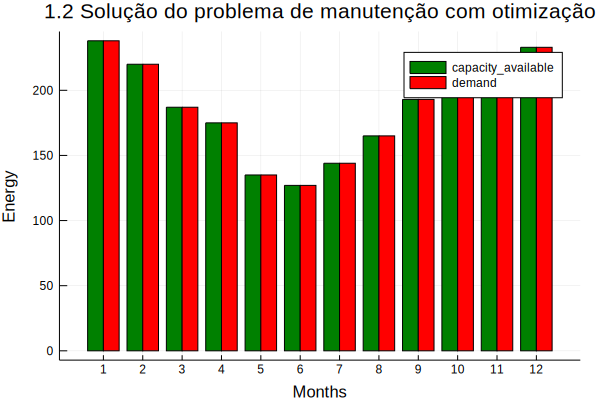

In [182]:
plot2_2

## 1.3 Potência disponível relativa ponderada pela demanda

In [183]:
G3 = G
d3 = d
nplants3 = length(G3)
nmonths3 = length(d3);

In [184]:
m3 = Model(solver = CbcSolver())

@variable(m3, x[1:nplants3, 1:nmonths3], Bin)
@variable(m3, α)

#Toda usina desliga uma vez no ano
@constraintref constraints1[1:nplants3]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m3, sum(x[plant, 1:nmonths3]) >= 1)
end

#α deve ser maior do que todas as diferenças relativas entre a capacidade disponível e a demanda do mês
@constraintref constraints2[1:nmonths3]
for month in eachindex(constraints2)
    constraints2[month] = @constraint(m3, α >= (sum(G3 .* (1 .- x[1:nplants3, month])) - d3[month]) / d3[month])
end

#A demanda sempre deve ser suprida
@constraintref constraints3[1:nmonths3]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m3, sum(G3 .* (1 .- x[1:nplants3, month])) - d3[month] >= 0)
end

@objective(m3, Min, α);

In [185]:
solve(m3)
@show getvalue(α)
schedule_matrix3 = getvalue(x)

getvalue(α) = 0.0


15×12 Array{Float64,2}:
 0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0
 1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0
 0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0

In [186]:
dados3, plot1_3, plot2_3 = dados_e_plot(G3, schedule_matrix3, d3, "1.3 Potência disponível relativa ponderada pela demanda", legend = true)
dados3

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[9],238.0
2,2,"[2, 9, 14]",220.0
3,3,"[4, 5, 10]",187.0
4,4,"[1, 2, 5, 8, 9, 14]",175.0
5,5,"[1, 2, 3, 4, 9, 10, 14, 15]",135.0
6,6,"[4, 6, 7, 9, 10, 11, 15]",127.0
7,7,"[1, 3, 5, 7, 8, 12]",144.0
8,8,"[2, 7, 9, 11, 12, 13]",165.0
9,9,"[1, 8, 10, 14]",193.0


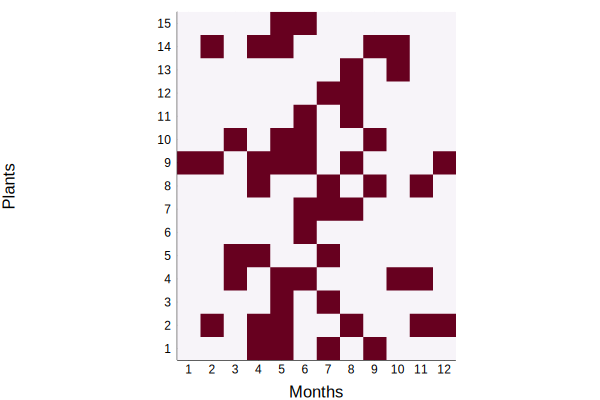

In [187]:
plot1_3

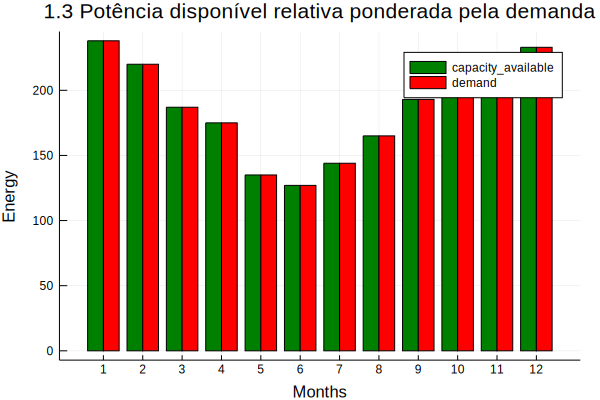

In [188]:
plot2_3

## 1.4 Restrição de potência disponível com margem de 10% da demanda

In [189]:
G4 = G
d4 = d
C4_δ = 5
nplants4 = length(G4)
nmonths4 = length(d4);

In [190]:
m4 = Model(solver = CbcSolver())

@variable(m4, x[1:nplants4, 1:nmonths4], Bin)
@variable(m4, α)
@variable(m4, δ[1:nmonths4])

#Toda usina desliga uma vez no ano
@constraintref constraints1[1:nplants4]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m4, sum(x[plant, 1:nmonths4]) >= 1)
end

#α deve ser maior do que todas as diferenças relativas entre a capacidade disponível e a demanda do mês
@constraintref constraints2[1:nmonths4]
for month in eachindex(constraints2)
    constraints2[month] = @constraint(m4, α >= (sum(G4 .* (1 .- x[1:nplants4, month])) - d4[month]) / d4[month])
end

#Agora há uma variável pra que a margem da demanda possa não ser cumprida (com alto custo)
@constraintref constraints3[1:nmonths4]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m4, sum(G4 .* (1 .- x[1:nplants4, month])) + δ[month] >= 1.1 * d4[month])
end

@constraintref constraints4[1:nmonths4]
for month in eachindex(constraints4)
    constraints4[month] = @constraint(m4, 0 <= δ[month] <= 0.1 * d4[month])
end

@objective(m4, Min, α + sum(δ) * C4_δ);

In [191]:
solve(m4)
@show getvalue(α)
@show getvalue(δ)
schedule_matrix4 = getvalue(x)

getvalue(α) = 0.10454545454545448
getvalue(δ) = [13.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.3]


15×12 Array{Float64,2}:
 0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0

In [192]:
dados4, plot1_4, plot2_4 = dados_e_plot(G4, schedule_matrix4, d4, "1.4 Restrição de potência disponível com margem de 10% da demanda", legend = true)
dados4

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[],248.0
2,2,[2],243.0
3,3,"[1, 2, 7, 10]",206.0
4,4,"[1, 2, 5, 11]",193.0
5,5,"[1, 2, 3, 4, 7, 8, 9, 11]",149.0
6,6,"[1, 6, 7, 8, 11, 14, 15]",140.0
7,7,"[4, 7, 10, 12, 13]",159.0
8,8,"[3, 5, 9, 14]",182.0
9,9,"[8, 9, 14]",213.0


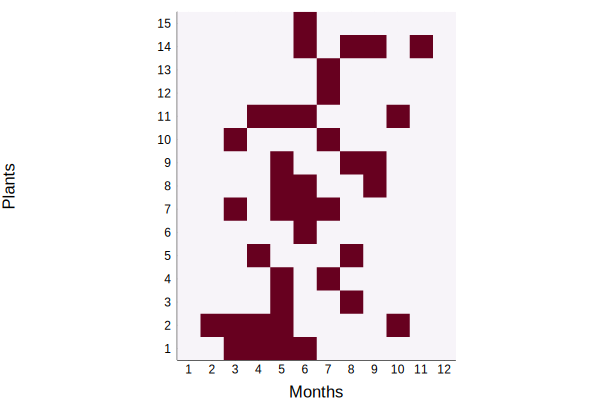

In [193]:
plot1_4

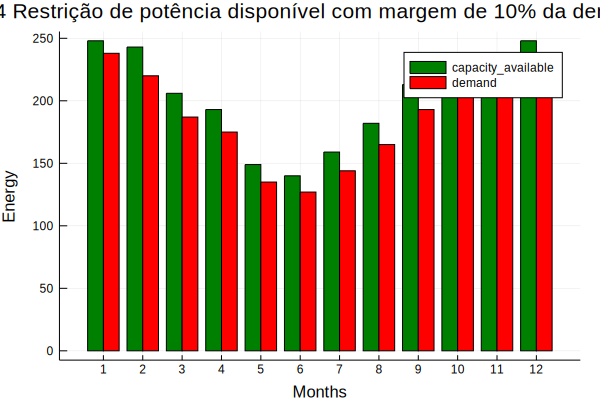

In [194]:
plot2_4

## 1.5 Utilizar cenários de demanda

### Valor esperado na função objetivo

In [195]:
G5 = G
Ns5 = Ns
d5 = ds
nplants5 = length(G5)
nmonths5 = size(d5)[1];

In [196]:
m5 = Model(solver = CbcSolver())

@variable(m5, x[1:nplants5, 1:nmonths5], Bin)
@variable(m5, α[1:nmonths5, 1:Ns5])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants5]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m5, sum(x[plant, 1:nmonths5]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths5, 1:Ns5]
for month in 1:nmonths5
    for scenario in 1:Ns5
        constraints2[month, scenario] = @constraint(m5, sum(G5 .* (1 .- x[1:nplants5, month])) >= d5[month, scenario])
    end
end

@constraintref constraints3[1:nmonths5, 1:Ns5]
for month in 1:nmonths5
    for scenario in 1:Ns5
        constraints3[month, scenario] = @constraint(m5, α[month, scenario] >= sum(G5 .* (1 .- x[1:nplants5, month])) - d5[month, scenario])
    end
end

@objective(m5, Min, sum(sum(α[month, scenario] for scenario in 1:Ns5) / Ns5 for month in 1:nmonths5));

In [197]:
solve(m5)
@show getobjectivevalue(m5)
schedule_matrix5 = getvalue(x)

getobjectivevalue(m5) = 580.0000000000001


15×12 Array{Float64,2}:
 0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0
 0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

In [198]:
dados5, plot1_5, plot2_5 = dados_e_plot(G5, schedule_matrix5, d5, "1.5 Utilizar cenários de demanda", legend = true)
dados5

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[14],235.0
2,2,"[4, 5, 8]",195.0
3,3,"[1, 2, 5, 7, 15]",186.0
4,4,"[1, 5, 7, 8, 13, 15]",167.0
5,5,"[1, 3, 6, 7, 12, 13]",135.0
6,6,"[3, 6, 7, 8, 9, 12, 14]",122.0
7,7,"[1, 5, 6, 9, 10, 11]",136.0
8,8,"[1, 2, 4, 5, 6, 14]",147.0
9,9,"[5, 6, 7]",186.0


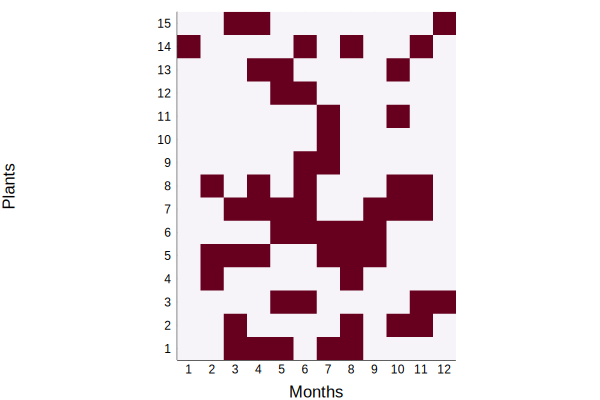

In [199]:
plot1_5

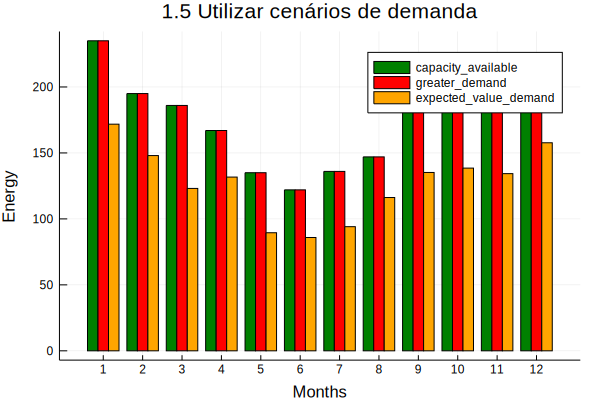

In [200]:
plot2_5

### Valor esperado na restrição

In [201]:
G5_2 = G
d5_2 = ds

Ns5_2 = Ns
nplants5_2 = length(G5_2)
nmonths5_2 = size(d5_2)[1];

In [202]:
Ed5_2 = [sum(d5_2[month, :]) / Ns5_2 for month in 1:nmonths5_2];

In [203]:
m5_2 = Model(solver = CbcSolver())

@variable(m5_2, x[1:nplants5_2, 1:nmonths5_2], Bin)
@variable(m5_2, α[1:nmonths5_2])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants5_2]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m5_2, sum(x[plant, 1:nmonths5_2]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths5_2, 1:Ns5_2]
for month in 1:nmonths5_2
    for scenario in 1:Ns5_2
        constraints2[month, scenario] = @constraint(m5_2, sum(G5_2 .* (1 .- x[1:nplants5_2, month])) >= d5_2[month, scenario])
    end
end

@constraintref constraints3[1:nmonths5_2]
for month in 1:nmonths5_2
    constraints3[month] = @constraint(m5_2, α[month] >= sum(G5_2 .* (1 .- x[1:nplants5_2, month])) - Ed5_2[month])
end

@objective(m5_2, Min, sum(α));

In [204]:
solve(m5_2)
@show getobjectivevalue(m5_2)
schedule_matrix5_2 = getvalue(x)

getobjectivevalue(m5_2) = 580.0


15×12 Array{Float64,2}:
 0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
 0.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0
 0.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0

In [205]:
dados5_2, plot1_5_2, plot2_5_2 = dados_e_plot(G5_2, schedule_matrix5_2, d5_2, "1.5 Utilizar cenários de demanda", legend = true)
dados5_2

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[14],235.0
2,2,"[2, 4, 7, 9, 14]",195.0
3,3,"[1, 4, 8, 9, 13]",186.0
4,4,"[1, 2, 6, 8, 9, 13]",167.0
5,5,"[1, 2, 7, 8, 10, 11, 13, 14, 15]",135.0
6,6,"[2, 3, 5, 11, 12, 13, 15]",122.0
7,7,"[6, 7, 8, 12, 13, 15]",136.0
8,8,"[2, 4, 5, 8, 9, 10, 14]",147.0
9,9,"[2, 5, 8, 9, 13]",186.0


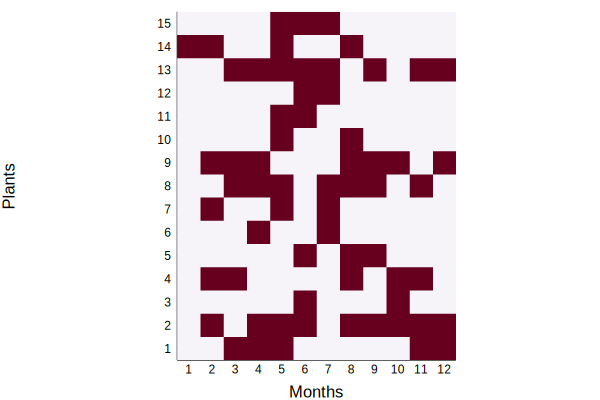

In [206]:
plot1_5_2

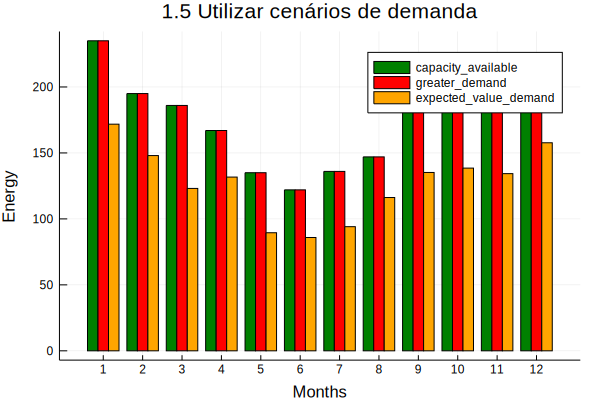

In [240]:
plot2_5_2

### Comparação entre o valor esperado na função objetivo e na restrição

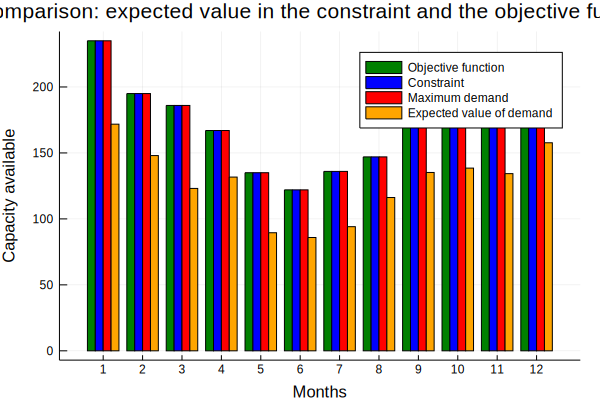

In [241]:
comp5and5_2 = comparison(ds, G, dados5, schedule_matrix5, dados5_2, schedule_matrix5_2; xlabel1 = "Objective function", xlabel2 = "Constraint", title = "Comparison: expected value in the constraint and the objective function", legend1 = true)
comp5and5_2[1]

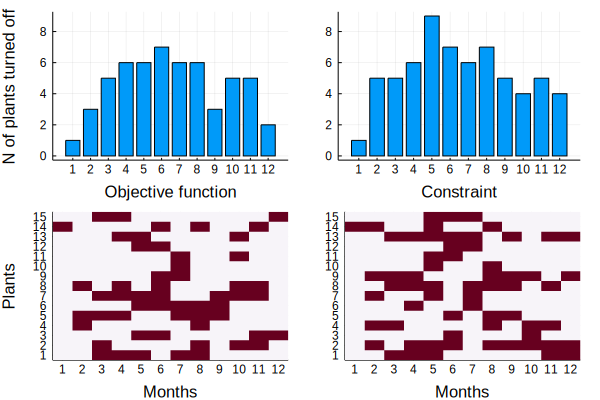

In [242]:
comp5and5_2[2]

## 1.6 Utilizar cenários de renovável e demanda líquida

In [243]:
G6 = G
Ns6 = Ns
d6 = dsR
nplants6 = length(G6)
nmonths6 = size(d6)[1];

In [244]:
m6 = Model(solver = CbcSolver())

@variable(m6, x[1:nplants6, 1:nmonths6], Bin)
@variable(m6, α[1:Ns6])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6, sum(x[plant, 1:nmonths6]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6, 1:Ns6]
for month in 1:nmonths6
    for scenario in 1:Ns6
        constraints2[month, scenario] = @constraint(m6, sum(G6 .* (1 .- x[1:nplants6, month])) >= d6[month, scenario])
    end
end

@constraintref constraints3[1:nmonths6, 1:Ns6]
for month in 1:nmonths6
    for scenario in 1:Ns6
        constraints3[month, scenario] = @constraint(m6, α[scenario] >= sum(G6 .* (1 .- x[1:nplants6, month])) - d6[month, scenario])
    end
end

@objective(m6, Min, sum(α[scenario] for scenario in 1:Ns6) / Ns6);

In [245]:
solve(m6)
@show getobjectivevalue(m6)
@show getvalue(α)
schedule_matrix6 = getvalue(x)

getobjectivevalue(m6) = 99.0
getvalue(α) = [68.0, 109.0, 107.0, 110.0, 90.0, 108.0, 91.0, 109.0, 103.0, 95.0]


15×12 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0
 1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0
 0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0
 1.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0
 0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0
 0.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0
 1.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0

In [246]:
dados6, plot1_6, plot2_6 = dados_e_plot(G6, schedule_matrix6, d6, "1.6 Utilizar cenários de renovável e demanda líquida", legend = true)
dados6

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[1, 2, 4, 14]",202.0
2,2,"[1, 3, 9, 11, 13, 14, 15]",149.0
3,3,"[1, 2, 5, 7, 10, 13, 15]",154.0
4,4,"[1, 4, 5, 7, 8, 11]",161.0
5,5,"[1, 2, 6, 7, 8, 9, 11, 13, 14]",130.0
6,6,"[4, 6, 11, 12, 14, 15]",119.0
7,7,"[1, 3, 4, 5, 12, 13]",133.0
8,8,"[5, 11, 12, 13, 14]",151.0
9,9,"[1, 2, 4, 5, 9, 10, 14]",149.0


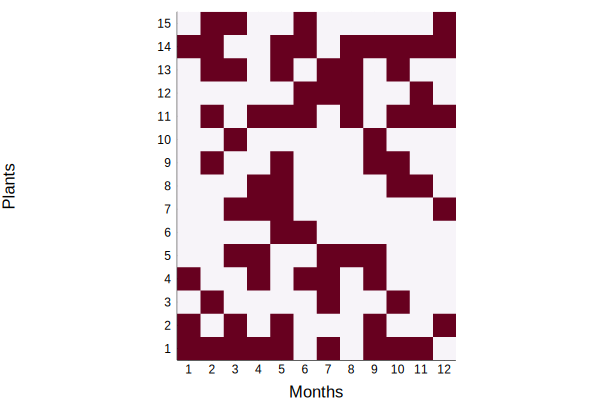

In [247]:
plot1_6

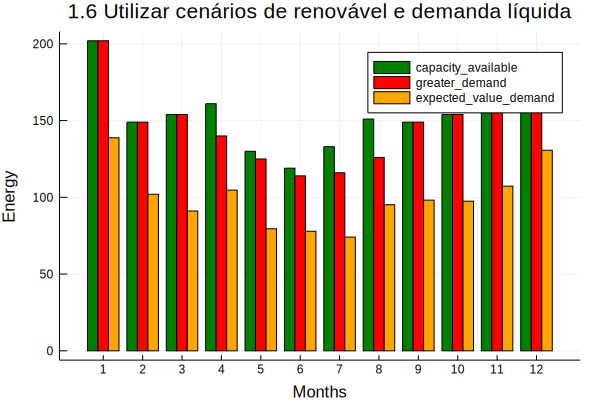

In [248]:
plot2_6

## 1.6.1 CVaR determinístico nas restrições

In [249]:
G6_1 = G
θ6_1 = θ
Ns6_1 = 10
d6_1 = dsR
nCVaR6_1 = Int(floor(θ6_1 * Ns6_1))
nplants6_1 = length(G6_1)
nmonths6_1 = size(d6_1)[1];

In [250]:
CVaR_d6_1 = zeros(nmonths6_1)
for month in 1:nmonths6_1
    CVaR_d6_1[month] = sum(sort(d6_1[month, :])[(Ns6_1 - nCVaR6_1 + 1):Ns6_1]) / nCVaR6_1
end

In [251]:
m6_1 = Model(solver = CbcSolver())

@variable(m6_1, x[1:nplants6_1, 1:nmonths6_1], Bin)
@variable(m6_1, α)

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6_1]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6_1, sum(x[plant, 1:nmonths6_1]) >= 1)
end

#=@constraintref constraints2[1:nmonths6_1]
for month in 1:nmonths6_1
    constraints2[month] = @constraint(m6_1, sum(G6_1 .* (1 .- x[1:nplants6_1, month])) >= CVaR_d6_1[month])
end=#

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6_1, 1:Ns6_1]
for month in 1:nmonths6_1
    for scenario in 1:Ns6_1
        constraints2[month, scenario] = @constraint(m6_1, sum(G6_1 .* (1 .- x[1:nplants6_1, month])) >= d6_1[month, scenario])
    end
end

@constraintref constraints3[1:nmonths6_1]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m6_1, α >= sum(G6_1 .* (1 .- x[1:nplants6_1, month])) - CVaR_d6_1[month])
end

@objective(m6_1, Min, α);

In [252]:
@show solve(m6_1)
@show getobjectivevalue(m6_1)
schedule_matrix6_1 = getvalue(x)

solve(m6_1) = :Optimal
getobjectivevalue(m6_1) = 18.0


15×12 Array{Float64,2}:
 0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0
 0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
 0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
 0.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0
 1.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0
 0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0

In [253]:
dados6_1, plot1_6_1, plot2_6_1 = dados_e_plot(G6_1, schedule_matrix6_1, d6_1, "1.6.1 CVaR determinístico nas restrições", CVaR = CVaR_d6_1, legend = true)
dados6_1

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[8, 10, 13]",204.0
2,2,"[1, 3, 8, 9, 11, 13, 14]",154.0
3,3,"[1, 2, 4, 5, 10, 15]",155.0
4,4,"[4, 5, 7, 9, 10, 11]",153.0
5,5,"[1, 2, 4, 7, 8, 9, 11, 13, 14, 15]",127.0
6,6,"[4, 6, 11, 12, 14, 15]",119.0
7,7,"[1, 2, 3, 4, 5, 12, 13]",128.0
8,8,"[3, 5, 11, 12, 13, 14]",131.0
9,9,"[2, 4, 5, 7, 8, 10, 13]",151.0


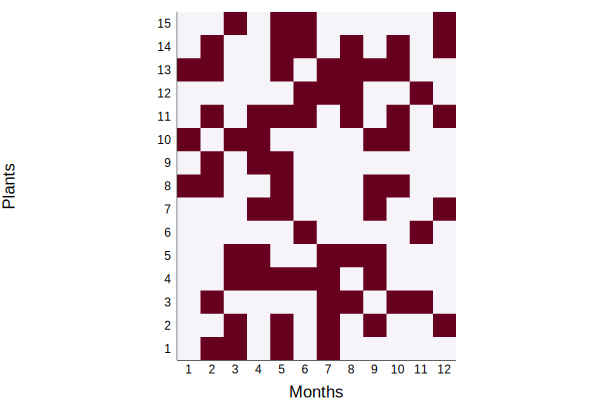

In [254]:
plot1_6_1

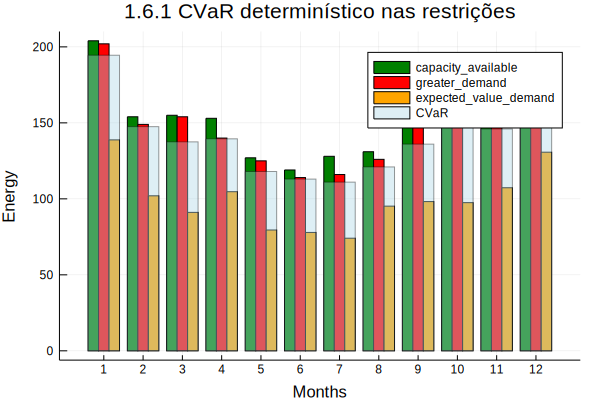

In [255]:
plot2_6_1

## 1.6.2 CVaR como problema de otimização na função objetivo

Um $\alpha$ para cada cenário

In [306]:
G6_2 = G
d6_2 = dsR
θ6_2 = θ

Ns6_2 = Ns
nplants6_2 = length(G6_2)
nmonths6_2 = size(d6_2)[1];

In [307]:
m6_2 = Model(solver = CbcSolver())

@variable(m6_2, x[1:nplants6_2, 1:nmonths6_2], Bin)
@variable(m6_2, α[1:Ns6_2])
@variable(m6_2, z)
@variable(m6_2, δ[1:Ns6_2])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6_2]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6_2, sum(x[plant, 1:nmonths6_2]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6_2, 1:Ns6_2]
for month in 1:nmonths6_2
    for scenario in 1:Ns6_2
        constraints2[month, scenario] = @constraint(m6_2, sum(G6_2 .* (1 .- x[1:nplants6_2, month])) >= d6_2[month, scenario])
    end
end

@constraintref constraints3[1:nmonths6_2, 1:Ns6_2]
for month in 1:nmonths6_2
    for scenario in 1:Ns6_2
        constraints3[month, scenario] = @constraint(m6_2, α[scenario] >= sum(G6_2 .* (1 .- x[1:nplants6_2, month])) - d6_2[month, scenario])
    end
end

@constraintref constraints4[1:Ns6_2]
for scenario in eachindex(constraints4)
    constraints4[scenario] = @constraint(m6_2, δ[scenario] <= z - α[scenario])
end

@constraintref constraints5[1:Ns6_2]
for scenario in eachindex(constraints5)
    constraints5[scenario] = @constraint(m6_2, δ[scenario] <= 0)
end

#@expression(m6_2, C, z - sum(1 / Ns6_2 * δ[scenario] / (1 - θ6_2) for scenario in 1:Ns6_2))

@objective(m6_2, Min, z - sum(1 / Ns6_2 * δ[scenario] / (1 - θ6_2) for scenario in 1:Ns6_2));

In [308]:
@show solve(m6_2)
@show getvalue(α)
@show getvalue(z)
@show getvalue(δ)
schedule_matrix6_2 = getvalue(x)

solve(m6_2) = :Optimal
getvalue(α) = [76.0, 109.0, 107.0, 110.0, 91.0, 108.0, 91.0, 109.0, 103.0, 95.0]
getvalue(z) = 91.00000000000004
getvalue(δ) = [0.0, -18.0, -16.0, -19.0, 0.0, -17.0, 0.0, -18.0, -12.0, -4.0]


15×12 Array{Float64,2}:
 0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0
 0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0
 1.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
 1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0
 0.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0

In [309]:
dados6_2, plot1_6_2, plot2_6_2 = dados_e_plot(G6_2, schedule_matrix6_2, d6_2, "1.6.2 CVaR como problema de otimização na função objetivo", legend = true)
dados6_2

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[2, 4, 9, 14]",202.0
2,2,"[1, 2, 3, 7, 9, 11, 13, 14]",154.0
3,3,"[1, 4, 5, 7, 9, 13, 14]",155.0
4,4,"[4, 5, 7, 8, 11]",171.0
5,5,"[1, 2, 4, 7, 8, 9, 11, 13, 14, 15]",127.0
6,6,"[4, 6, 11, 14, 15]",151.0
7,7,"[1, 3, 4, 5, 12, 13]",133.0
8,8,"[5, 10, 11, 13, 14]",163.0
9,9,"[2, 3, 5, 7, 8, 12]",149.0


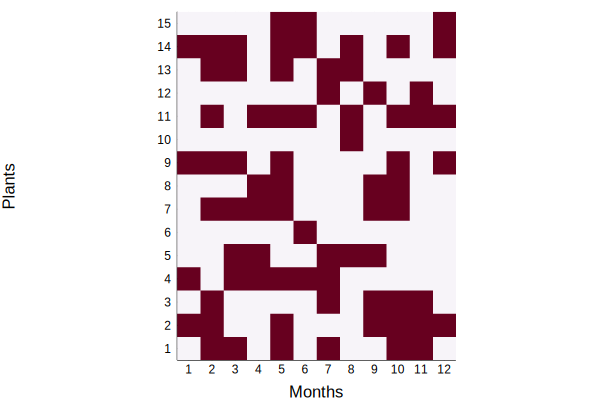

In [310]:
plot1_6_2

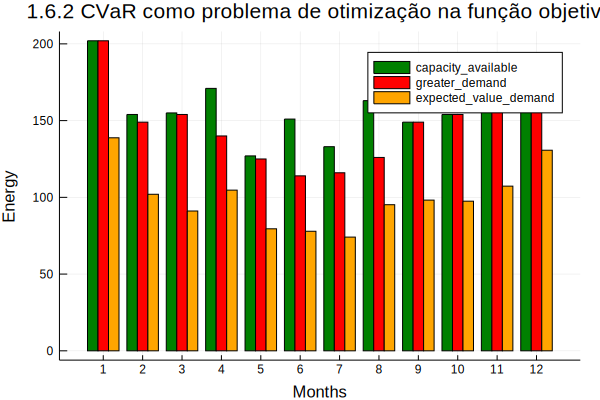

In [311]:
plot2_6_2

## Comparação entre o CVaR na função objetivo e na restrição

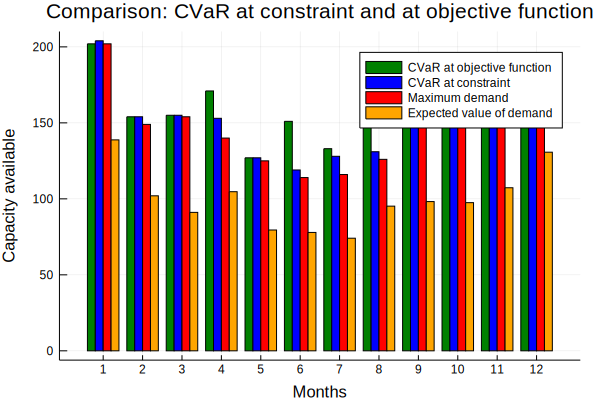

In [312]:
comp6_2and6_1 = comparison(dsR, G, dados6_2, schedule_matrix6_2, dados6_1, schedule_matrix6_1, xlabel2 = "CVaR at constraint", xlabel1 = "CVaR at objective function", title = "Comparison: CVaR at constraint and at objective function", legend1 = true)
comp6_2and6_1[1]

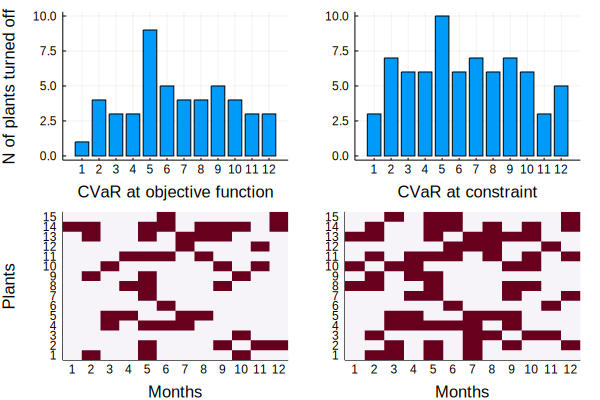

In [264]:
comp6_2and6_1[2]

## Comparação entre o CVaR e o valor esperado

Para fins de comparação, refaço o valor esperado na restrição, porém agora com renovável.

In [265]:
G5_3 = G
d5_3 = dsR

Ns5_3 = Ns
nplants5_3 = length(G5_3)
nmonths5_3 = size(d5_3)[1];

In [266]:
Ed5_3 = [sum(d5_3[month, :]) / Ns5_3 for month in 1:nmonths5_3];

In [267]:
m5_3 = Model(solver = CbcSolver())

@variable(m5_3, x[1:nplants5_3, 1:nmonths5_3], Bin)
@variable(m5_3, α[1:nmonths5_3])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants5_3]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m5_3, sum(x[plant, 1:nmonths5_3]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths5_3, 1:Ns5_3]
for month in 1:nmonths5_3
    for scenario in 1:Ns5_3
        constraints2[month, scenario] = @constraint(m5_3, sum(G5_3 .* (1 .- x[1:nplants5_3, month])) >= d5_3[month, scenario])
    end
end

@constraintref constraints3[1:nmonths5_3]
for month in 1:nmonths5_3
    constraints3[month] = @constraint(m5_3, α[month] >= sum(G5_3 .* (1 .- x[1:nplants5_3, month])) - Ed5_3[month])
end

@objective(m5_3, Min, sum(α));

In [268]:
solve(m5_3)
@show getobjectivevalue(m5_3)
schedule_matrix5_3 = getvalue(x)

getobjectivevalue(m5_3) = 580.0


15×12 Array{Float64,2}:
 0.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0

In [270]:
dados5_3, plot1_5_3, plot2_5_3 = dados_e_plot(G5_3, schedule_matrix5_3, d5_3, "1.5 Utilizar cenários de demanda", legend = true)
dados5_3

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[2, 7, 8, 9, 13]",202.0
2,2,"[2, 3, 7, 8, 9, 10, 13, 14]",149.0
3,3,"[1, 2, 3, 7, 9, 13, 14, 15]",154.0
4,4,"[1, 3, 5, 9, 12, 14]",140.0
5,5,"[2, 3, 4, 5, 6, 8, 14]",125.0
6,6,"[1, 2, 3, 5, 6, 12, 13]",114.0
7,7,"[1, 5, 6, 9, 12, 13, 14]",116.0
8,8,"[1, 2, 5, 8, 9, 10, 13, 14, 15]",126.0
9,9,"[1, 2, 5, 7, 9, 12, 13]",149.0


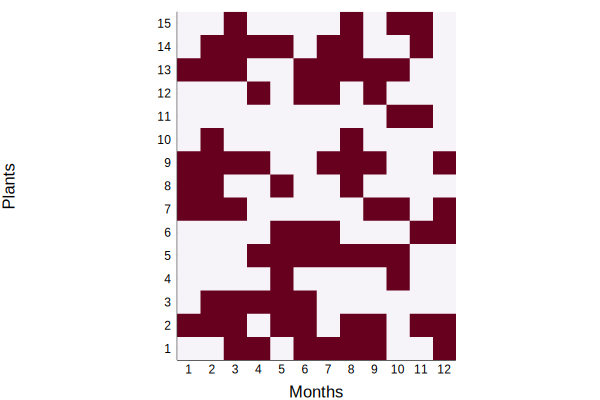

In [271]:
plot1_5_3

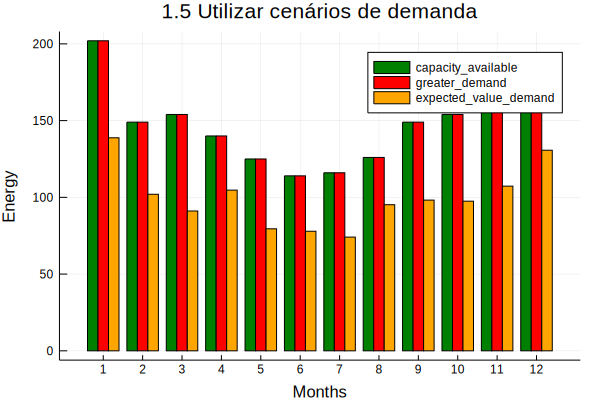

In [272]:
plot2_5_3

Comparação entre o CVaR na restrição e o valor esperado na restrição.

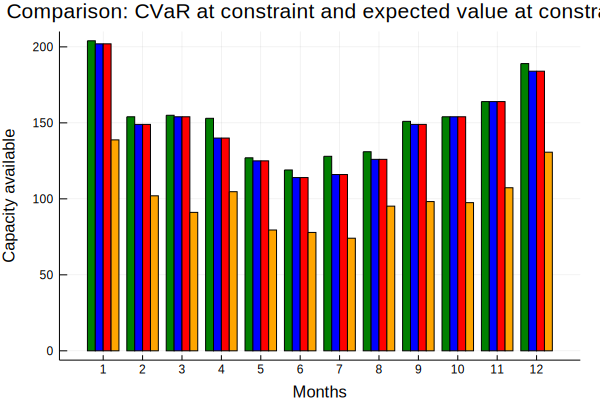

In [273]:
comp6_1and5_3 = comparison(dsR, G, dados6_1, schedule_matrix6_1, dados5_3, schedule_matrix5_3; xlabel1 = "CVaR at constraint", xlabel2 = "Expected value at constraint", title = "Comparison: CVaR at constraint and expected value at constraint")
comp6_1and5_3[1]

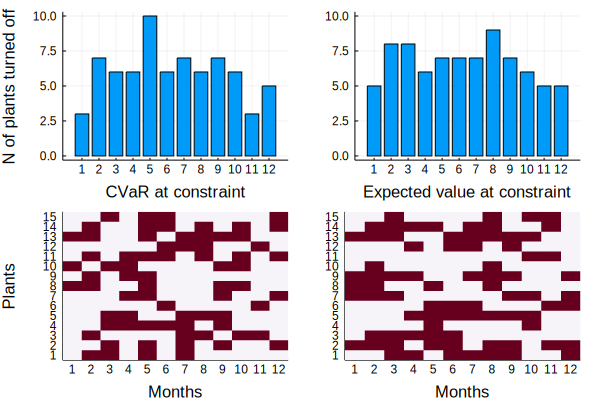

In [274]:
comp6_1and5_3[2]

## 1.6.3 Combinação convexa entre CVaR e valor esperado

In [313]:
G6_3 = G
d6_3 = dsR
θ6_3 = θ
λ6_3 = 0.5

Ns6_3 = Ns
nplants6_3 = length(G6_3)
nmonths6_3 = size(d6_3)[1];

In [314]:
m6_3 = Model(solver = CbcSolver())

@variable(m6_3, x[1:nplants6_3, 1:nmonths6_3], Bin)
@variable(m6_3, α[1:Ns6_3])
@variable(m6_3, z)
@variable(m6_3, δ[1:Ns6_3])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6_3]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6_3, sum(x[plant, 1:nmonths6_3]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6_3, 1:Ns6_3]
for month in 1:nmonths6_3
    for scenario in 1:Ns6_3
        constraints2[month, scenario] = @constraint(m6_3, sum(G6_3 .* (1 .- x[1:nplants6_3, month])) >= d6_3[month, scenario])
    end
end

@constraintref constraints3[1:nmonths6_3, 1:Ns6_3]
for month in 1:nmonths6_3
    for scenario in 1:Ns6_3
        constraints3[month, scenario] = @constraint(m6_3, α[scenario] >= sum(G6_3 .* (1 .- x[1:nplants6_3, month])) - d6_3[month, scenario])
    end
end

@constraintref constraints4[1:Ns6_3]
for scenario in eachindex(constraints4)
    constraints4[scenario] = @constraint(m6_3, δ[scenario] <= z - α[scenario])
end

@constraintref constraints5[1:Ns6_3]
for scenario in eachindex(constraints5)
    constraints5[scenario] = @constraint(m6_3, δ[scenario] <= 0)
end

@expression(m6_3, CVaR, z - sum(1 / Ns6_3 * δ[scenario] / (1 - θ6_3) for scenario in 1:Ns6_3))
@expression(m6_3, Eα, sum(α) / Ns6_3)

@objective(m6_3, Min, λ6_3 * CVaR + (1 - λ6_3) * Eα);

In [315]:
@show solve(m6_3)
@show getvalue(α)
@show getvalue(z)
@show getvalue(δ)
schedule_matrix6_3 = getvalue(x)

solve(m6_3) = :Optimal
getvalue(α) = [68.0, 109.0, 107.0, 110.0, 90.0, 108.0, 91.0, 109.0, 103.0, 95.0]
getvalue(z) = 91.00000000000004
getvalue(δ) = [0.0, -18.0, -16.0, -19.0, 0.0, -17.0, 0.0, -18.0, -12.0, -4.0]


15×12 Array{Float64,2}:
 0.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0
 0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0
 1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0
 0.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0

In [316]:
dados6_3, plot1_6_3, plot2_6_3 = dados_e_plot(G6_3, schedule_matrix6_3, d6_3, "1.6.3 Combinação convexa entre CVaR e valor esperado", legend = true)
dados6_3

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[2, 4, 9, 14]",202.0
2,2,"[1, 2, 3, 7, 9, 11, 13, 14]",154.0
3,3,"[1, 3, 5, 8, 11, 13]",154.0
4,4,"[1, 4, 5, 7, 8, 11]",161.0
5,5,"[1, 2, 4, 7, 8, 9, 11, 13, 14, 15]",127.0
6,6,"[4, 6, 11, 12, 14, 15]",119.0
7,7,"[1, 3, 4, 5, 12, 13]",133.0
8,8,"[5, 6, 11, 13, 14]",151.0
9,9,"[1, 5, 7, 9, 10, 11, 13]",149.0


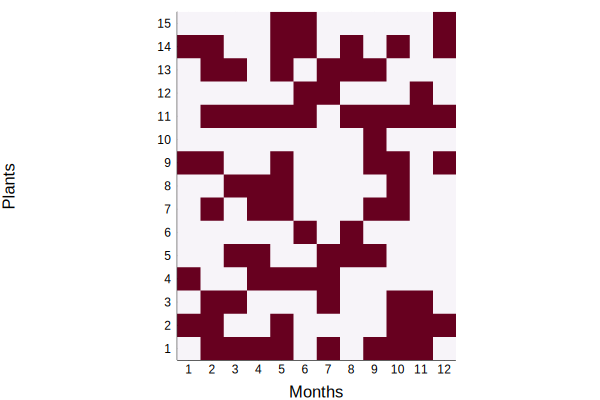

In [317]:
plot1_6_3

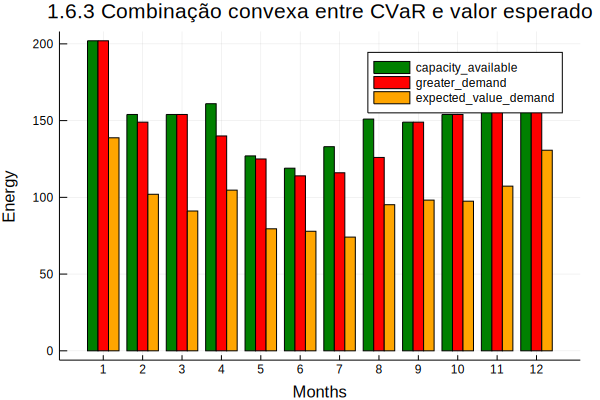

In [318]:
plot2_6_3

## 1.6.4 Custo de manutenção

É adicionado o custo de manutenção na função objetivo. Modelo com cenários de renovável e demanda líquida, um $\alpha$ por mês.

In [282]:
G6_4 = G
Ns6_4 = Ns
d6_4 = dsR
nplants6_4 = length(G6_4)
nmonths6_4 = size(d6_4)[1];

In [283]:
m6_4 = Model(solver = CbcSolver())

@variable(m6_4, x[1:nplants6_4, 1:nmonths6_4], Bin)
@variable(m6_4, α[1:nmonths6_4])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6_4]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6_4, sum(x[plant, 1:nmonths6_4]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6_4, 1:Ns6_4]
for month in 1:nmonths6_4
    for scenario in 1:Ns6_4
        constraints2[month, scenario] = @constraint(m6_4, sum(G6_4 .* (1 .- x[1:nplants6_4, month])) >= d6_4[month, scenario])
    end
end

#α maior do que a diferença entre geração e demanda
@constraintref constraints3[1:nmonths6_4, 1:Ns6_4]
for month in 1:nmonths6_4
    for scenario in 1:Ns6_4
        constraints3[month, scenario] = @constraint(m6_4, α[month] >= sum(G6_4 .* (1 .- x[1:nplants6_4, month])) - d6_4[month, scenario])
    end
end

@expression(m6_4, sumK, sum(x))
@expression(m6_4, sumα, sum(α))

@objective(m6_4, Min, sumα + sumK);

In [284]:
solve(m6_4)
@show getobjectivevalue(m6_4)
schedule_matrix6_4 = getvalue(x)

getobjectivevalue(m6_4) = 1119.0


15×12 Array{Float64,2}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0
 0.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0

In [288]:
dados6_4, plot1_6_4, plot2_6_4 = dados_e_plot(G6_4, schedule_matrix6_4, d6_4, "1.6.4 Custo de manutenção", legend = true)
dados6_4

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[6, 14]",203.0
2,2,"[5, 6, 8, 12]",149.0
3,3,"[1, 3, 6, 12]",154.0
4,4,"[3, 5, 6, 12]",141.0
5,5,"[2, 4, 5, 6, 12, 14]",125.0
6,6,"[5, 6, 9, 10, 12, 15]",114.0
7,7,"[4, 5, 6, 7, 10, 12]",116.0
8,8,"[4, 5, 6, 11, 12]",126.0
9,9,"[4, 6, 11, 12]",149.0


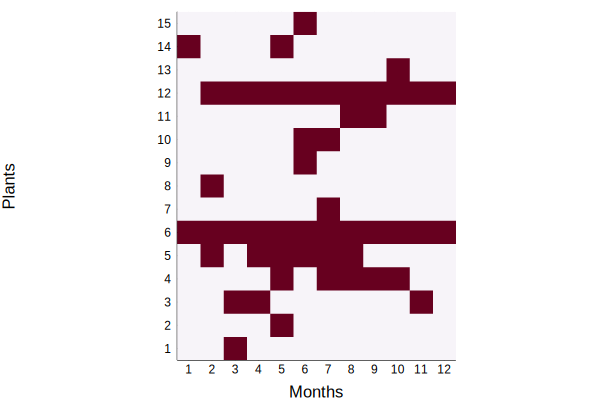

In [289]:
plot1_6_4

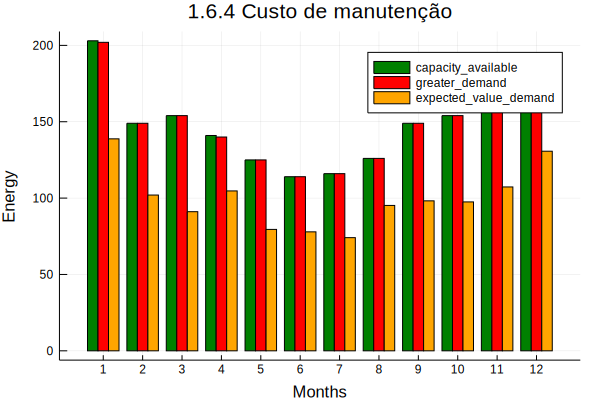

In [290]:
plot2_6_4

## 1.7 Considerando custo de geração e custo de manutenção

É adicionado o custo de geração na função objetivo. Modelo com cenários de renovável e demanda líquida, um $\alpha$ por mês.

In [291]:
G7 = G
Ns7 = Ns
d7 = dsR
cg7 = cg
nplants7 = length(G7)
nmonths7 = size(d7)[1];

In [292]:
m7 = Model(solver = CbcSolver())

@variable(m7, x[1:nplants7, 1:nmonths7], Bin)
@variable(m7, α[1:nmonths7])
@variable(m7, g[1:nplants7, 1:nmonths7] >= 0)

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants7]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m7, sum(x[plant, 1:nmonths7]) >= 1)
end

#A geração em cada mês deve superar a demanda em cada mês e cenário
@constraintref constraints2[1:nmonths7, 1:Ns7]
for month in 1:nmonths7
    for scenario in 1:Ns7
        constraints2[month, scenario] = @constraint(m7, sum(g[1:nplants7, month]) >= d7[month, scenario])
    end
end

@constraintref constraints4[1:nmonths7, 1:Ns7]
for month in 1:nmonths7
    for scenario in 1:Ns7
        constraints4[month, scenario] = @constraint(m7, α[month] >= sum(g[1:nplants7, month]) - d7[month, scenario])
    end
end

#Limite da geração
@constraintref constraints3[1:nplants7, 1:nmonths7]
for plant in 1:nplants7
    for month in 1:nmonths7
        constraints3[plant, month] = @constraint(m7, g[plant, month] <= G7[plant] * (1 - x[plant, month]))
    end
end

#=@constraintref constraints4[1:nplants7, 1:nmonths7]
for plant in 1:nplants7
    for month in 1:nmonths7
        constraints4[plant, month] = @constraint(m7, g[plant, month] >= 0)
    end
end=#

@expression(m7, sumK, sum(x))
@expression(m7, sumα, sum(α))
@expression(m7, sumcg, sum(sum(g[1:nplants7, month] .* cg7) for month in 1:nmonths7))

@objective(m7, Min, sumα + sumK + sumcg);

In [293]:
solve(m7)
@show getobjectivevalue(m7)
g7 = getvalue(g)
schedule_matrix7 = getvalue(x)

getobjectivevalue(m7) = 1082.0


15×12 Array{Float64,2}:
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

In [296]:
dados7, plot1_7, plot2_7 = dados_e_plot(g7, schedule_matrix7, d7, "1.7 Considerando custo de geração e custo de manutenção", legend = true)
dados7

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[],202.0
2,2,"[1, 3, 9]",149.0
3,3,[10],154.0
4,4,[7],140.0
5,5,[2],125.0
6,6,"[6, 11, 14]",114.0
7,7,"[5, 12]",116.0
8,8,[13],126.0
9,9,[4],149.0


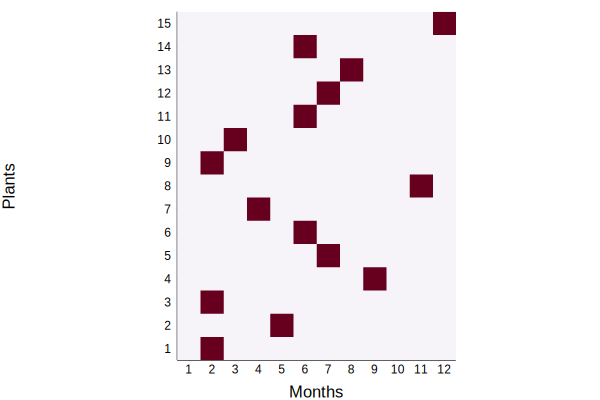

In [297]:
plot1_7

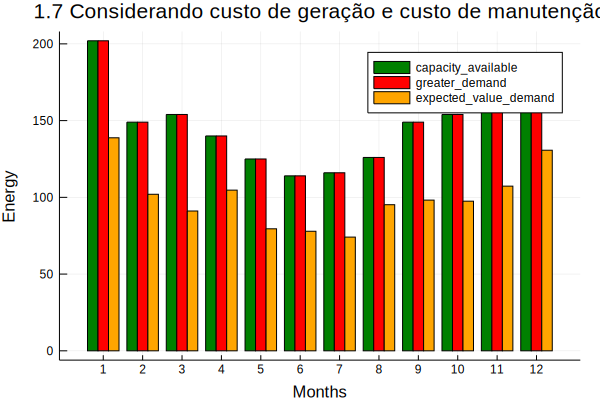

In [298]:
plot2_7

Vamos agora considerar $\alpha$ por mês e cenário.

In [299]:
G7_2 = G
Ns7_2 = Ns
d7_2 = dsR
cg7_2 = cg
nplants7_2 = length(G7_2)
nmonths7_2 = size(d7_2)[1];

In [300]:
m7_2 = Model(solver = CbcSolver())

@variable(m7_2, x[1:nplants7_2, 1:nmonths7_2], Bin)
@variable(m7_2, α[1:nmonths7_2, 1:Ns7_2])
@variable(m7_2, g[1:nplants7_2, 1:nmonths7_2] >= 0)

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants7_2]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m7_2, sum(x[plant, 1:nmonths7_2]) >= 1)
end

#A geração em cada mês deve superar a demanda em cada mês e cenário
@constraintref constraints2[1:nmonths7_2, 1:Ns7_2]
for month in 1:nmonths7_2
    for scenario in 1:Ns7_2
        constraints2[month, scenario] = @constraint(m7_2, sum(g[1:nplants7_2, month]) >= d7_2[month, scenario])
    end
end

@constraintref constraints4[1:nmonths7_2, 1:Ns7_2]
for month in 1:nmonths7_2
    for scenario in 1:Ns7_2
        constraints4[month, scenario] = @constraint(m7_2, α[month, scenario] >= sum(g[1:nplants7_2, month]) - d7_2[month, scenario])
    end
end

#Limite da geração
@constraintref constraints3[1:nplants7_2, 1:nmonths7_2]
for plant in 1:nplants7_2
    for month in 1:nmonths7_2
        constraints3[plant, month] = @constraint(m7_2, g[plant, month] <= G7_2[plant] * (1 - x[plant, month]))
    end
end

#=@constraintref constraints4[1:nplants7_2, 1:nmonths7_2]
for plant in 1:nplants7_2
    for month in 1:nmonths7_2
        constraints4[plant, month] = @constraint(m7_2, g[plant, month] >= 0)
    end
end=#

@expression(m7_2, sumα, sum(α) / Ns7_2)
@expression(m7_2, sumK, sum(x))
@expression(m7_2, sumcg, sum(sum(g[1:nplants7_2, month] .* cg7_2) for month in 1:nmonths7_2))

@objective(m7_2, Min, sumα + sumK + sumcg);

In [301]:
solve(m7_2)
@show getobjectivevalue(m7_2)
g7_2 = getvalue(g)
schedule_matrix7_2 = getvalue(x)

getobjectivevalue(m7_2) = 595.0000000000002


15×12 Array{Float64,2}:
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0

In [303]:
dados7_2, plot1_7_2, plot2_7_2 = dados_e_plot(g7_2, schedule_matrix7_2, d7_2, "1.7 Considerando custo de geração e custo de manutenção", legend = true)
dados7_2

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[],202.0
2,2,"[1, 3]",149.0
3,3,"[9, 10]",154.0
4,4,[8],140.0
5,5,"[2, 11]",125.0
6,6,"[7, 14, 15]",114.0
7,7,"[4, 5]",116.0
8,8,[13],126.0
9,9,[],149.0


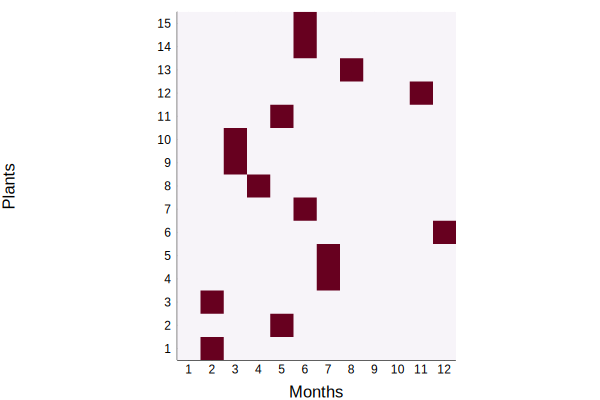

In [304]:
plot1_7_2

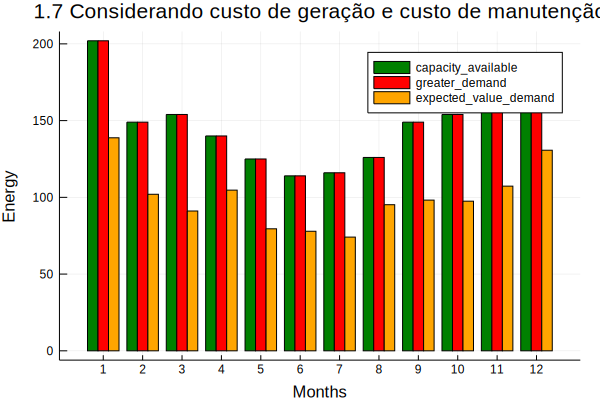

In [305]:
plot2_7_2